<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/8.recurrent_neural_networks/8_6_concise_implementation_of_recurrent_neural_networks_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import re
import hashlib
import os
import tarfile
import zipfile
import requests
import matplotlib.pyplot as plt
import random
import torch
from torch.nn import functional as F
from torch import nn
import math
import time
import numpy as np
import matplotlib.pyplot as plt

In [49]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [50]:
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

In [51]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [52]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [53]:
def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [54]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [55]:
def tokenize(lines, token='word'):

  if token == 'word':
    return [line.split() for line in lines]
  elif token == 'char':
    return [list(line) for line in lines]
  else:
    print('ERROR: unknow token type: ' + token)

In [56]:
def count_corpus(tokens):

  if len(tokens) == 0 or isinstance(tokens[0], list):
   tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)

In [57]:
class Vocab:

  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):

    if tokens is None:
      tokens = []
    if reserved_tokens is None:
      reserved_tokens = []
    counter = count_corpus(tokens)

    self._token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse=True)
    self.idx_to_token = ['<unk>'] + reserved_tokens
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    for token, freq in self._token_freqs:
      if freq < min_freq:
        break;
      if token not in self.token_to_idx:
        self.idx_to_token.append(token)
        self.token_to_idx[token] = len(self.idx_to_token) - 1
  
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    else:
      return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    else:
      return [self.to_tokens(idx) for idx in indices]

  @property
  def unk(self):
    return 0

  @property
  def token_freqs(self):
    return self._token_freqs

In [58]:
def load_corpus_time_machine(max_tokens=-1):

  lines = read_time_machine()
  tokens = tokenize(lines, 'char')
  vocab = Vocab(tokens)

  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    corpus = corpus[:max_tokens]
  return corpus, vocab

In [59]:
def seq_data_iter_random(corpus, batch_size, num_steps):

  corpos = corpus[random.randint(0, num_steps - 1):]
  num_subseqs = (len(corpos) - 1) // num_steps
  initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
  random.shuffle(initial_indices)

  def data(pos):
    return corpus[pos: pos + num_steps]
  
  num_batches = num_subseqs // batch_size

  for i in range(0, batch_size * num_batches, batch_size):
    initial_indices_per_batch = initial_indices[i: i + batch_size]
    X = [data(idx) for idx in initial_indices_per_batch]
    Y = [data(idx + 1) for idx in initial_indices_per_batch]
    yield torch.tensor(X), torch.tensor(Y)

In [60]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):

  offset = random.randint(0, num_steps)
  num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
  Xs = torch.tensor(corpus[offset: offset + num_tokens])
  Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])

  Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
  num_batches = Xs.shape[1] // num_steps

  for i in range(0, num_steps * num_batches, num_steps):
    X = Xs[:, i: i + num_steps]
    Y = Ys[:, i: i + num_steps]
    yield X, Y

In [61]:
class SeqDataLoader:

  def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):

    if use_random_iter:
      self.data_iter_fn = seq_data_iter_random
    else:
      self.data_iter_fn = seq_data_iter_sequential

    self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
    self.batch_size, self.num_steps = batch_size, num_steps

  def __iter__(self):

    return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [62]:
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [63]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [64]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [65]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [66]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))

In [67]:
Y, state_new = rnn_layer(X, state)

In [68]:
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [69]:
class RNNModel(nn.Module):

  def __init__(self, rnn_layer, vocab_size, **kwargs):
    super(RNNModel, self).__init__(**kwargs)

    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    else:
      self.num_directions = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
  
  def forward(self, inputs, state):

    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    Y, state = self.rnn(X, state)
    output = self.linear(Y.reshape((-1, Y.shape[-1])))
    return output, state

  def begin_state(self, device, batch_size=1):
    if not isinstance(self.rnn, nn.LSTM):
      return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
    else:
      return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))


In [70]:
def predict_ch8(prefix, num_preds, net, vocab, device):

  state = net.begin_state(batch_size=1, device= device)
  outputs = [vocab[prefix[0]]]
  get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
  for y in prefix[1:]:
    _, state = net(get_input(), state)
    outputs.append(vocab[y])
  
  for _ in range(num_preds):
    y, state = net(get_input(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))

  return ''.join([vocab.idx_to_token[i] for i in outputs])

In [71]:
device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

'time travellerfjffyyyjff'

In [72]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [73]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [74]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [75]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [76]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):

  state, timer = None, Timer()
  metric = Accumulator(2)
  for X, Y in train_iter:
    if state is None or use_random_iter:
      state = net.begin_state(batch_size=X.shape[0], device=device)
    else:
      if isinstance(net, nn.Module) and not isinstance(state, tuple):
        state.detach_()
      else:
        for s in state:
          s.detach_()
    y = Y.T.reshape(-1)
    X, y = X.to(device), y.to(device)
    y_hat, state = net(X, state)
    l = loss(y_hat, y.long()).mean()
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      grad_clipping(net, 1)
      updater.step()
    else:
      l.backward()
      grad_clipping(net, 1)
      updater(batch_size=1)
    metric.add(l * y.numel(), y.numel())
  return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [77]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
  
  loss = nn.CrossEntropyLoss()
  if isinstance(net, nn.Module):
    updater = torch.optim.SGD(net.parameters(), lr)
  else:
    updater = lambda batch_size: sgd(net.params, lr, batch_size)
  
  predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)

  ui_x = []
  ui_y = []
  for epoch in range(num_epochs):
    ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
    if (epoch + 1) % 10 == 0:
      print(predict('time traveller'))
      ui_x.append(epoch + 1)
      ui_y.append(ppl)

  
  print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
  print(predict('time traveller'))
  print(predict('traveller'))

  plt.plot(ui_x, ui_y, 'r')
  plt.show()

time traveller an the the the the the the the the the the the th
time traveller and the the that therering that and the the the t
time traveller the thing the thing the thing the thing the thing
time traveller the this the thing the thing the this the thing t
time travellereatlene the the thase the the thate the the thate 
time traveller thith siment on the this the mad that le prould f
time traveller thicg the gime traveller thicg the gime traveller
time traveller and ffre thing that be tha fired thicklest and is
time traveller tare man at filler the ght lighte scather and sow
time traveller of che ston thas ouls oonth three alathered can t
time traveller ffremenoc wasdof thate and and they this way has 
time traveller of chithe beas thin thane will sonn thes think th
time traveller cat of spacingle th ans and the gery ingwtonn gst
time traveller ffter as it the gromet mat i buthe e sige that us
time traveller of cald the time traveller hat and havele ge thac
time traveller aro that i

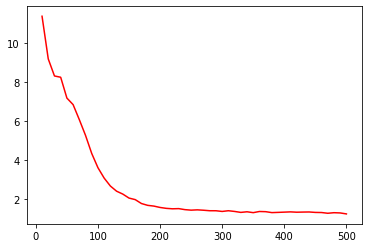

In [78]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)